In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/kaggle/input/sales-forecasting/train.csv')

print(df.head())
print(df.info())


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

# Preprocessing

In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

daily_sales = daily_sales.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

print(daily_sales.isnull().sum())


ds    0
y     0
dtype: int64


# Train/Validation Split

In [5]:
split_index = int(len(daily_sales) * 0.9)

train_df = daily_sales.iloc[:split_index]
val_df = daily_sales.iloc[split_index:]

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)


Train shape: (1107, 2)
Validation shape: (123, 2)


# Initialize Prophet model

In [6]:
model = Prophet(
    growth='linear',            
    yearly_seasonality=True,    
    weekly_seasonality=True,   
    daily_seasonality=False   
)


In [7]:
model.fit(train_df)
future = model.make_future_dataframe(periods=len(val_df), freq='D')
forecast = model.predict(future)


17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing


# Evaluate performance

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


val_forecast = forecast[forecast['ds'].isin(val_df['ds'])]

preds = preds.dropna(subset=['y', 'yhat'])

print(preds.isna().sum())

mae = mean_absolute_error(preds['y'], preds['yhat'])
rmse = mean_squared_error(preds['y'], preds['yhat'], squared=False)

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")


y       0
yhat    0
dtype: int64
Validation MAE: 1977.17
Validation RMSE: 2674.36


# Sales forecast

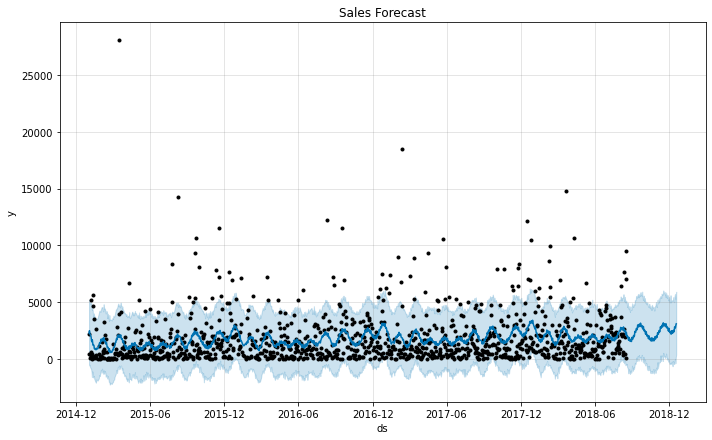

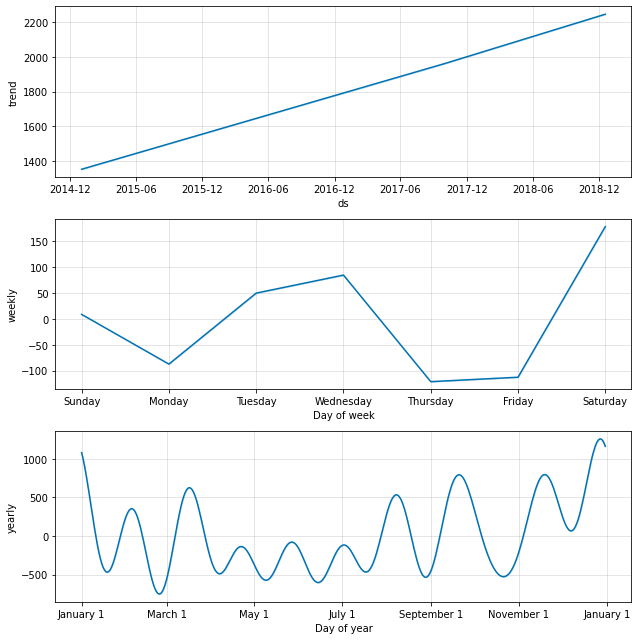

In [10]:
model.plot(forecast)
plt.title("Sales Forecast")
plt.show()

model.plot_components(forecast)
plt.show()


# Forecast vs Actual

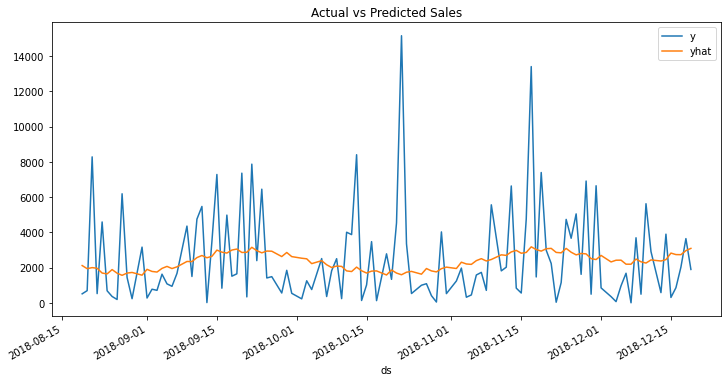

In [13]:
preds[['y', 'yhat']].plot(figsize=(12,6))
plt.title("Actual vs Predicted Sales")
plt.show()


# Residuals

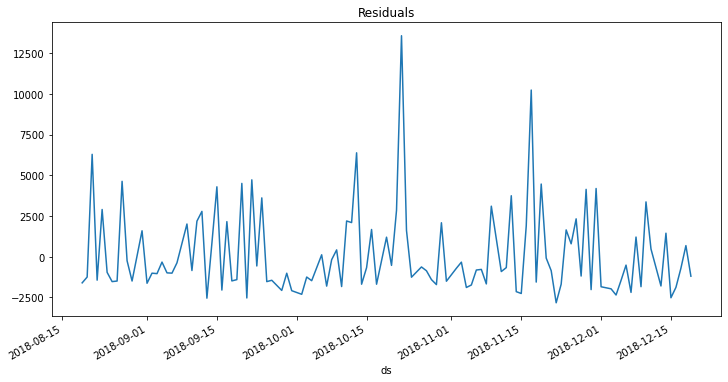

In [14]:
preds['residual'] = preds['y'] - preds['yhat']
preds['residual'].plot(figsize=(12,6), title="Residuals")
plt.show()
